In [1]:
import pandas as pd
import pathlib
import numpy as np
import json
import re
from matplotlib import pyplot
from tqdm import tqdm

In [2]:
import tensorflow as tf 
tf.__version__

'2.1.0-rc1'

In [3]:
pd.set_option('display.max_columns', 200)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score,classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.tree import DecisionTreeClassifier,export_graphviz

In [85]:
df_swt = pd.read_csv("./swt_v2_cleaned.csv").drop('Unnamed: 0', axis=1)

8544	xavier	18%
9839	xavier	6%
10418	

In [6]:
patient_kept = [8544,9839,10418]  ## 9578 ##9104

In [86]:
patient_kept = [9578,8544,11333,7032,11077,4456,11870,10418,302,9866,6175,1770,9231,6440,9104,8295,10489,2521,8460,7252,6904,9839,5943,11869,10106,1587,4892,7128,12941,7234,5034,258,6514,6544,281,9540,3401,8476,6413,12973,10591,8889,10455,9842,6546,3977,6083,13085,7584,5452,9630,10158,6811,5633,2806,13103,2991,8174]


In [87]:
#filtrage sur le patient
df_swt=df_swt[df_swt['Patient'].isin(patient_kept)]

In [88]:
#suppression des lignes où le label est vide
df_swt.dropna(subset=['label'],inplace=True)

In [89]:
#remplacement des valeurs de label par 0 si c'est inférieur à 0.5, et 1 sinon
df_swt['label']= df_swt['label'].apply(lambda x: 0 if (x==0) else 1)

In [90]:
#remplacement des valeurs "inf" par Nan
df_swt = df_swt.replace([np.inf, -np.inf], np.nan)

In [91]:
# remplacement des valeurs "Nan" par la moyenne de l'examen

df_swt2 = df_swt.groupby(df_swt['cle_exam']).transform(lambda x: x.fillna(x.mean()))

In [92]:
df_swt2['cle_exam'] = df_swt['cle_exam'].values

In [93]:
#definition d'une fonction pour transformer les series temporelles:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
	# input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (j, i)) for j in df.columns]
	# forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (j)) for j in df.columns]
        else:
            names += [('%s(t+%d)' % (j, i)) for j in df.columns]
	# put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
	# drop rows with NaN values
    if dropnan:
        agg = agg.iloc[n_in:,]
    return agg

In [94]:
#definition d'une variable qui indique le nombre de périodes que nous allons prendre en compte
nb_period = 3

In [95]:
# creation d'un dataframe où les series sont temporalisée examen par examen
df_swt_temp = pd.DataFrame()

for i in df_swt.cle_exam.unique():
    df_swt_temp = pd.concat([df_swt_temp,series_to_supervised(df_swt2[df_swt2['cle_exam']== i],nb_period,1)])

In [96]:
dropped_columns=[ 
 'interval_index',
 'Dossier Patient',
 'exam_duration',
 'Pan_vs_SWT',
 'SWT_vs_XQRS',
 'interval_start_time',
 'sampen',
 'max_duration',
 'mean_nni%',
 'csi%',
 'hf%']

features_non_temp =['cle_exam']

numerical_feat = ['mean_nni',
 'sdnn',
 'sdsd',
 'nni_50',
 'pnni_50',
 'nni_20',
 'pnni_20',
 'rmssd',
 'median_nni',
 'range_nni',
 'cvsd',
 'cvnni',
 'mean_hr',
 'max_hr',
 'min_hr',
 'std_hr',
 'lf',
 'hf',
 'vlf',
 'lf_hf_ratio',
 'csi',
 'cvi',
 'Modified_csi',
 'sd1',
 'sd2',
 'ratio_sd2_sd1']

categorical_feat = ['Patient']
features_temp = numerical_feat+categorical_feat

In [97]:
#definition de la liste des colonnes à dropper (dynamique en fonction du nombre de période)
dropped_columns_temp = [s+ "(t-"+str(j)+")" for s in dropped_columns for j in range(1,nb_period+1)]
dropped_columns_temp += [s+ "(t)" for s in dropped_columns]
#dropped_columns_temp += ["Patient(t-"+str(j)+")" for j in range(1,nb_period+1)]

In [98]:
df_swt_temp =df_swt_temp.drop(dropped_columns_temp,axis = 1)

In [99]:
features_list = ['%s(t-%d)' % (i,j) for i in features_temp for j in range(1,nb_period+1)]
features_list +=  ['%s(t)' % i for i in features_temp]
features_list +=  ['%s(t)' % i for i in features_non_temp]
features_list = sorted(features_list)
target_variable = "label(t)"

X = df_swt_temp.loc[:,features_list]
Y = df_swt_temp.loc[:,target_variable]

In [100]:
## split test/train

X_train, X_test,Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state =42, stratify = Y)


In [ ]:
#### methode de split test/train en utilisant le dossier "dev/train"
#df_swt2_train = df_swt_temp[df_swt_temp['cle_exam(t)'].str.startswith('train')]
#df_swt2_test  = df_swt_temp[df_swt_temp['cle_exam(t)'].str.startswith('dev')]

#X_train = df_swt2_train.loc[:,features_list]
#X_test = df_swt2_test.loc[:,features_list]
#Y_train = df_swt2_train.loc[:,target_variable]
#Y_test = df_swt2_test.loc[:,target_variable]

In [101]:
# calculate basic figures to share ours results
print("nb exams sur le train: ",X_train['cle_exam(t)'].unique().shape[0])
print("nb exams sur le test: ",X_test['cle_exam(t)'].unique().shape[0])
print("nb lignes sur le train: ",X_train.shape[0])
print("nb lignes sur le test: ",X_test.shape[0])

nb exams sur le train:  745
nb exams sur le test:  745
nb lignes sur le train:  46675
nb lignes sur le test:  11669


In [102]:
#drop "cle_exam"
cle_exam_list = ['cle_exam(t)']

X_train = X_train.drop(cle_exam_list,axis=1)
X_test = X_test.drop(cle_exam_list,axis=1)

In [103]:
# Normalization
numeric_transformer = StandardScaler()

# OHE / dummyfication

categorical_indices =[X_train.columns.get_loc('%s(t-%d)' %  (i,j)) for i in categorical_feat for j in range(1,nb_period+1)]
categorical_indices += [X_train.columns.get_loc('%s(t)' %  i) for i in categorical_feat]
categorical_indices = sorted(categorical_indices)

numeric_indices =[X_train.columns.get_loc('%s(t-%d)' %  (i,j)) for i in numerical_feat for j in range(1,nb_period+1)]
numeric_indices += [X_train.columns.get_loc('%s(t)' %  i) for i in numerical_feat]
numeric_indices = sorted(numeric_indices)


categorical_transformer = OneHotEncoder(drop='first')

featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_indices),    
        ('num', numeric_transformer, numeric_indices)
        ]
    )

X_train_fit = featureencoder.fit_transform(X_train)
print("...Done")
print(X_train_fit[0:5,:])

...Done
[[ 0.          0.          0.         ... -0.05196005 -0.06998762
  -0.08514056]
 [ 0.          0.          0.         ... -0.32281445 -0.33929791
  -0.34252474]
 [ 0.          0.          0.         ... -0.23301859 -0.25968439
  -0.27883636]
 [ 0.          0.          0.         ...  0.06643304  0.06862589
   0.07095865]
 [ 0.          0.          0.         ...  0.91596119  0.85214506
   0.80584775]]


In [104]:
X_test_fit = featureencoder.transform(X_test)

In [105]:
X_train_fit.shape

(46675, 332)

# Entrainement d'un Decision Tree

In [106]:
classifier = DecisionTreeClassifier()

In [107]:
classifier.fit(X_train_fit,Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [108]:
Y_train_pred = classifier.predict(X_train_fit)
Y_test_pred = classifier.predict(X_test_fit)

In [109]:
print("Accuracy on train set : ", accuracy_score(Y_train, Y_train_pred))
print("Accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))

Accuracy on train set :  1.0
Accuracy on test set :  0.8613420173108236


In [110]:
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[37695     0]
 [    0  8980]]

Confusion matrix on test set : 
[[8567  857]
 [ 761 1484]]



In [111]:
print("recall score on train set : ", recall_score(Y_train,Y_train_pred))
print("recall score on test set : ", recall_score(Y_test,Y_test_pred))

recall score on train set :  1.0
recall score on test set :  0.6610244988864142


In [112]:
print("precision score on train set : ", precision_score(Y_train,Y_train_pred))
print("precision score on test set : ", precision_score(Y_test,Y_test_pred))

precision score on train set :  1.0
precision score on test set :  0.6339171294318667


In [113]:
print("f1 score on train set : ", f1_score(Y_train,Y_train_pred))
print("f1 score on test set : ", f1_score(Y_test, Y_test_pred))

f1 score on train set :  1.0
f1 score on test set :  0.6471870911469689


In [114]:
print("Classification Report Train")
print(classification_report(Y_train,Y_train_pred))

Classification Report Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37695
           1       1.00      1.00      1.00      8980

    accuracy                           1.00     46675
   macro avg       1.00      1.00      1.00     46675
weighted avg       1.00      1.00      1.00     46675



In [115]:
print("Classification Report Test")
print(classification_report(Y_test,Y_test_pred))

Classification Report Test
              precision    recall  f1-score   support

           0       0.92      0.91      0.91      9424
           1       0.63      0.66      0.65      2245

    accuracy                           0.86     11669
   macro avg       0.78      0.79      0.78     11669
weighted avg       0.86      0.86      0.86     11669



# Entrainement d'un LSTM

In [143]:
#reshape specifique en 3D pour le format attendu pour le LSTM

param2 =int(X_train_fit.shape[1]/(nb_period+1))

X_train_resh = X_train_fit.reshape((X_train_fit.shape[0],nb_period+1,param2))
X_test_resh = X_test_fit.reshape((X_test_fit.shape[0], nb_period+1, param2))
#print(X_train_resh.shape, Y_train.shape, X_test_resh.shape, Y_test.shape)

In [144]:
# design network
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(50, input_shape=(X_train_resh.shape[1], X_train_resh.shape[2])))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [145]:
# Créons un learning rate schedule pour décroitre le learning rate à mesure que nous entrainons le modèle 
initial_learning_rate = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1090,
    decay_rate=0.96,
    staircase=True)

# Utilisation d'un compileur simple avec un optimiseur Adam pour le calcul de nos gradients 
optimizer= tf.keras.optimizers.Adam(
    learning_rate = lr_schedule
)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryCrossentropy(),
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])

In [146]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                26800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 26,851
Trainable params: 26,851
Non-trainable params: 0
_________________________________________________________________


In [150]:
# fit network
history = model.fit(X_train_resh, Y_train, epochs=100, batch_size=72, validation_data=(X_test_resh, Y_test), verbose=2, shuffle=False)


Train on 46675 samples, validate on 11669 samples
Epoch 1/100
46675/46675 - 2s - loss: 0.1804 - binary_crossentropy: 0.1804 - precision_2: 0.8945 - recall_2: 0.7078 - val_loss: 0.2679 - val_binary_crossentropy: 0.2679 - val_precision_2: 0.7810 - val_recall_2: 0.6147
Epoch 2/100
46675/46675 - 2s - loss: 0.1793 - binary_crossentropy: 0.1793 - precision_2: 0.8955 - recall_2: 0.7099 - val_loss: 0.2679 - val_binary_crossentropy: 0.2679 - val_precision_2: 0.7812 - val_recall_2: 0.6156
Epoch 3/100
46675/46675 - 2s - loss: 0.1781 - binary_crossentropy: 0.1781 - precision_2: 0.8961 - recall_2: 0.7117 - val_loss: 0.2679 - val_binary_crossentropy: 0.2679 - val_precision_2: 0.7832 - val_recall_2: 0.6165
Epoch 4/100
46675/46675 - 2s - loss: 0.1772 - binary_crossentropy: 0.1772 - precision_2: 0.8970 - recall_2: 0.7138 - val_loss: 0.2679 - val_binary_crossentropy: 0.2679 - val_precision_2: 0.7827 - val_recall_2: 0.6160
Epoch 5/100
46675/46675 - 2s - loss: 0.1761 - binary_crossentropy: 0.1761 - precis

Epoch 39/100
46675/46675 - 2s - loss: 0.1544 - binary_crossentropy: 0.1544 - precision_2: 0.9139 - recall_2: 0.7590 - val_loss: 0.2708 - val_binary_crossentropy: 0.2708 - val_precision_2: 0.7847 - val_recall_2: 0.6316
Epoch 40/100
46675/46675 - 2s - loss: 0.1540 - binary_crossentropy: 0.1540 - precision_2: 0.9142 - recall_2: 0.7596 - val_loss: 0.2708 - val_binary_crossentropy: 0.2708 - val_precision_2: 0.7846 - val_recall_2: 0.6312
Epoch 41/100
46675/46675 - 2s - loss: 0.1537 - binary_crossentropy: 0.1537 - precision_2: 0.9146 - recall_2: 0.7600 - val_loss: 0.2709 - val_binary_crossentropy: 0.2709 - val_precision_2: 0.7847 - val_recall_2: 0.6316
Epoch 42/100
46675/46675 - 2s - loss: 0.1533 - binary_crossentropy: 0.1533 - precision_2: 0.9153 - recall_2: 0.7609 - val_loss: 0.2710 - val_binary_crossentropy: 0.2710 - val_precision_2: 0.7847 - val_recall_2: 0.6316
Epoch 43/100
46675/46675 - 2s - loss: 0.1530 - binary_crossentropy: 0.1530 - precision_2: 0.9153 - recall_2: 0.7617 - val_loss: 

Epoch 77/100
46675/46675 - 2s - loss: 0.1450 - binary_crossentropy: 0.1450 - precision_2: 0.9229 - recall_2: 0.7788 - val_loss: 0.2731 - val_binary_crossentropy: 0.2731 - val_precision_2: 0.7837 - val_recall_2: 0.6374
Epoch 78/100
46675/46675 - 2s - loss: 0.1448 - binary_crossentropy: 0.1448 - precision_2: 0.9226 - recall_2: 0.7792 - val_loss: 0.2732 - val_binary_crossentropy: 0.2732 - val_precision_2: 0.7833 - val_recall_2: 0.6374
Epoch 79/100
46675/46675 - 2s - loss: 0.1447 - binary_crossentropy: 0.1447 - precision_2: 0.9228 - recall_2: 0.7795 - val_loss: 0.2732 - val_binary_crossentropy: 0.2732 - val_precision_2: 0.7837 - val_recall_2: 0.6374
Epoch 80/100
46675/46675 - 2s - loss: 0.1445 - binary_crossentropy: 0.1445 - precision_2: 0.9230 - recall_2: 0.7795 - val_loss: 0.2733 - val_binary_crossentropy: 0.2733 - val_precision_2: 0.7837 - val_recall_2: 0.6374
Epoch 81/100
46675/46675 - 2s - loss: 0.1444 - binary_crossentropy: 0.1444 - precision_2: 0.9230 - recall_2: 0.7800 - val_loss: 

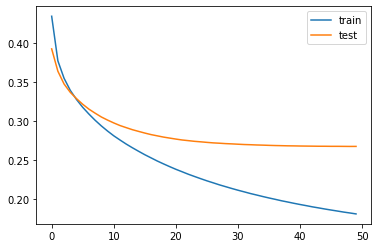

In [155]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [156]:
Y_train_pred2 = model.predict_classes(X_train_resh)
Y_test_pred2 = model.predict_classes(X_test_resh)

In [157]:
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train,Y_train_pred2))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred2))
print()

Confusion matrix on train set : 
[[37175   520]
 [ 1996  6984]]

Confusion matrix on test set : 
[[9026  398]
 [ 806 1439]]



In [158]:
print("Sensitivity (recall) score on train set : ", recall_score(Y_train,Y_train_pred2))
print("Sensitivity (recall) score on test set : ", recall_score(Y_test,Y_test_pred2))

Sensitivity (recall) score on train set :  0.777728285077951
Sensitivity (recall) score on test set :  0.6409799554565702


In [159]:
print("Classification Report Train")
print(classification_report(Y_train,Y_train_pred2))

Classification Report Train
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     37695
           1       0.93      0.78      0.85      8980

    accuracy                           0.95     46675
   macro avg       0.94      0.88      0.91     46675
weighted avg       0.95      0.95      0.94     46675



In [160]:
print("Classification Report Test")
print(classification_report(Y_test,Y_test_pred2))

Classification Report Test
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      9424
           1       0.78      0.64      0.71      2245

    accuracy                           0.90     11669
   macro avg       0.85      0.80      0.82     11669
weighted avg       0.89      0.90      0.89     11669

